# Outline
1. Set-up - Importing of packages and article text
2. Text Pre-Processing - Tokenization and cleaning of article text
3. Frequency Analysis - Analysis of word and noun phrase frequency for all articles

# Set-up

The following packages were used to analyze the frequency of words and phrases in the articles:
* `newspaper` to extract the content of articles
* `nltk` for NLP

In [1]:
from newspaper import Article
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import nltk
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk import RegexpParser
from nltk import Tree
import re

from sklearn.feature_extraction.text import TfidfVectorizer

Note that the program accepts a csv with two rows:
1. `title` - the title of the article
2. `url` - the url to the article

In [2]:
df = pd.read_csv('articles.csv')
df.head()

,title,url
0,Kia Launches EV6 In The Philippines With Compl...,https://cleantechnica.com/2023/04/02/kia-launc...
1,"The Ice Cream, A Small $5000 EV, May Spark Mor...",https://cleantechnica.com/2023/03/10/the-ice-c...
2,Used Car Market Forecasted to Exhibit an Incre...,https://finance.yahoo.com/news/used-car-market...
3,"Proton X90 full details – same Geely looks, 48...",https://paultan.org/2023/03/29/proton-x90-full...
4,Electric Scooters to Continue Skyrocketing in ...,https://finance.yahoo.com/news/electric-scoote...


## News Article Scraping
The `newspaper` package is used to scrape the content of news articles and add the texts to the dataframe. If the `Article()` function is unable to access the website, the row is left null and eventually dropped from the dataset.

In [3]:
def get_content(x):
    url = x['url']
    try:
        page = Article(url, language='en')
        page.download()
        page.parse()
        return page.text
    except:
        return np.nan

In [4]:
df['text'] = df.apply(get_content, axis=1)
df.head()

,title,url,text
0,Kia Launches EV6 In The Philippines With Compl...,https://cleantechnica.com/2023/04/02/kia-launc...,It is Kia Motors Philippines’ belief that in o...
1,"The Ice Cream, A Small $5000 EV, May Spark Mor...",https://cleantechnica.com/2023/03/10/the-ice-c...,"The Ice Cream, a popular small footprint elect..."
2,Used Car Market Forecasted to Exhibit an Incre...,https://finance.yahoo.com/news/used-car-market...,Data Bridge Market Research\n\nData Bridge Mar...
3,"Proton X90 full details – same Geely looks, 48...",https://paultan.org/2023/03/29/proton-x90-full...,"In Cars, Local News, Proton, Videos / By Hafri..."
4,Electric Scooters to Continue Skyrocketing in ...,https://finance.yahoo.com/news/electric-scoote...,"BOSTON, April 6, 2023 /PRNewswire/ --\n\nTwo-W..."


In [5]:
display(df.info())
df = df.dropna()
df = df[['title', 'text']]
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   21 non-null     object
 1   url     21 non-null     object
 2   text    20 non-null     object
dtypes: object(3)
memory usage: 632.0+ bytes


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 0 to 20
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   20 non-null     object
 1   text    20 non-null     object
dtypes: object(2)
memory usage: 480.0+ bytes


None

# Text Pre-Processing
The text is first tokenized (separated into words) then stop words ("the", "is", "an", etc.) are removed.

## Tokenizing
The text is tokenized using two methods: `nltk.word_tokenize` and `re.findall`. The latter was preferred since the former was unable to remove punctuations.

In [6]:
df['tokenized'] = df.apply(lambda row: nltk.word_tokenize(row['text']), axis=1)
df.head()

,title,text,tokenized
0,Kia Launches EV6 In The Philippines With Compl...,It is Kia Motors Philippines’ belief that in o...,"[It, is, Kia, Motors, Philippines, ’, belief, ..."
1,"The Ice Cream, A Small $5000 EV, May Spark Mor...","The Ice Cream, a popular small footprint elect...","[The, Ice, Cream, ,, a, popular, small, footpr..."
2,Used Car Market Forecasted to Exhibit an Incre...,Data Bridge Market Research\n\nData Bridge Mar...,"[Data, Bridge, Market, Research, Data, Bridge,..."
3,"Proton X90 full details – same Geely looks, 48...","In Cars, Local News, Proton, Videos / By Hafri...","[In, Cars, ,, Local, News, ,, Proton, ,, Video..."
4,Electric Scooters to Continue Skyrocketing in ...,"BOSTON, April 6, 2023 /PRNewswire/ --\n\nTwo-W...","[BOSTON, ,, April, 6, ,, 2023, /PRNewswire/, -..."


In [7]:
df['tokenized_re'] = df.apply(lambda row: re.findall('\w+', row['text']), axis=1)
df.head()

,title,text,tokenized,tokenized_re
0,Kia Launches EV6 In The Philippines With Compl...,It is Kia Motors Philippines’ belief that in o...,"[It, is, Kia, Motors, Philippines, ’, belief, ...","[It, is, Kia, Motors, Philippines, belief, tha..."
1,"The Ice Cream, A Small $5000 EV, May Spark Mor...","The Ice Cream, a popular small footprint elect...","[The, Ice, Cream, ,, a, popular, small, footpr...","[The, Ice, Cream, a, popular, small, footprint..."
2,Used Car Market Forecasted to Exhibit an Incre...,Data Bridge Market Research\n\nData Bridge Mar...,"[Data, Bridge, Market, Research, Data, Bridge,...","[Data, Bridge, Market, Research, Data, Bridge,..."
3,"Proton X90 full details – same Geely looks, 48...","In Cars, Local News, Proton, Videos / By Hafri...","[In, Cars, ,, Local, News, ,, Proton, ,, Video...","[In, Cars, Local, News, Proton, Videos, By, Ha..."
4,Electric Scooters to Continue Skyrocketing in ...,"BOSTON, April 6, 2023 /PRNewswire/ --\n\nTwo-W...","[BOSTON, ,, April, 6, ,, 2023, /PRNewswire/, -...","[BOSTON, April, 6, 2023, PRNewswire, Two, Whee..."


## Removal of Stopwords
The `stopwords` dataset of stopwords from `nltk.corpus` is used to remove stopwords from the tokens.

In [8]:
nltk.download('stopwords')
sw = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Clar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
from collections import deque
def rem_sw(row):
    out = deque()
    for r in row['tokenized_re']:
        if not r.lower() in sw:
            out.append(r)
    return list(out)

df['cleaned_tokens'] = df.apply(rem_sw, axis=1)
df.head()

,title,text,tokenized,tokenized_re,cleaned_tokens
0,Kia Launches EV6 In The Philippines With Compl...,It is Kia Motors Philippines’ belief that in o...,"[It, is, Kia, Motors, Philippines, ’, belief, ...","[It, is, Kia, Motors, Philippines, belief, tha...","[Kia, Motors, Philippines, belief, order, prom..."
1,"The Ice Cream, A Small $5000 EV, May Spark Mor...","The Ice Cream, a popular small footprint elect...","[The, Ice, Cream, ,, a, popular, small, footpr...","[The, Ice, Cream, a, popular, small, footprint...","[Ice, Cream, popular, small, footprint, electr..."
2,Used Car Market Forecasted to Exhibit an Incre...,Data Bridge Market Research\n\nData Bridge Mar...,"[Data, Bridge, Market, Research, Data, Bridge,...","[Data, Bridge, Market, Research, Data, Bridge,...","[Data, Bridge, Market, Research, Data, Bridge,..."
3,"Proton X90 full details – same Geely looks, 48...","In Cars, Local News, Proton, Videos / By Hafri...","[In, Cars, ,, Local, News, ,, Proton, ,, Video...","[In, Cars, Local, News, Proton, Videos, By, Ha...","[Cars, Local, News, Proton, Videos, Hafriz, Sh..."
4,Electric Scooters to Continue Skyrocketing in ...,"BOSTON, April 6, 2023 /PRNewswire/ --\n\nTwo-W...","[BOSTON, ,, April, 6, ,, 2023, /PRNewswire/, -...","[BOSTON, April, 6, 2023, PRNewswire, Two, Whee...","[BOSTON, April, 6, 2023, PRNewswire, Two, Whee..."


# Frequency Analysis
Finally, the cleaned tokens are subjected to word frequency analysis and noun-phrase frequency analysis.

## Word Frequency
The `FreqDist` function from the `nltk` package was used to obtain word frequencies. The top $20$ words are then plotted.

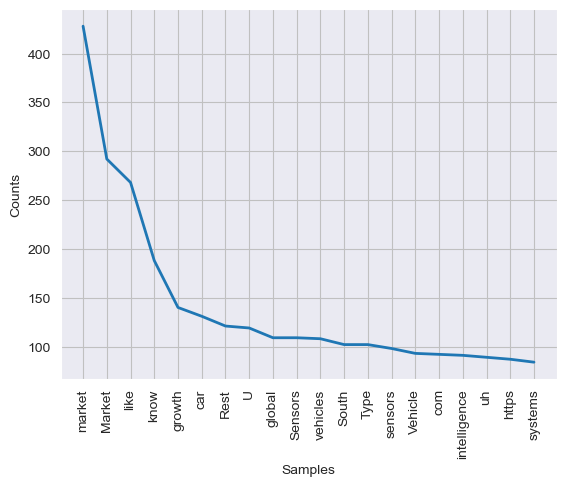

<AxesSubplot: xlabel='Samples', ylabel='Counts'>

In [10]:
allwords = []
for row in df['cleaned_tokens']:
    allwords += row

freq = nltk.FreqDist(allwords)
freq.plot(20)

## Noun Phrase Frequency
The text is first tokenized as with before, but, this time, noun phrases are accounted for. This might add additional context needed for coding.

In [12]:
# Defining a grammar & Parser
NP = "NP: {(<V\w+>|<NN\w?>)+.*<NN\w?>}"
chunker = RegexpParser(NP)

def get_continuous_chunks(text, chunk_func=ne_chunk):
    chunked = chunk_func(pos_tag(word_tokenize(text)))
    continuous_chunk = []
    current_chunk = []

    for subtree in chunked:
        if type(subtree) == Tree:
            current_chunk.append(" ".join([token for token, pos in subtree.leaves()]))
        elif current_chunk:
            named_entity = " ".join(current_chunk)
            if named_entity not in continuous_chunk:
                continuous_chunk.append(named_entity)
                current_chunk = []
        else:
            continue

    return continuous_chunk

df['chunk_tokens'] = df['text'].apply(lambda sent: get_continuous_chunks(sent, chunker.parse))
df.head()

,title,text,tokenized,tokenized_re,cleaned_tokens,chunk_tokens
0,Kia Launches EV6 In The Philippines With Compl...,It is Kia Motors Philippines’ belief that in o...,"[It, is, Kia, Motors, Philippines, ’, belief, ...","[It, is, Kia, Motors, Philippines, belief, tha...","[Kia, Motors, Philippines, belief, order, prom...","[is Kia Motors Philippines ’ belief, Korean ca..."
1,"The Ice Cream, A Small $5000 EV, May Spark Mor...","The Ice Cream, a popular small footprint elect...","[The, Ice, Cream, ,, a, popular, small, footpr...","[The, Ice, Cream, a, popular, small, footprint...","[Ice, Cream, popular, small, footprint, electr...","[Ice Cream, China —, called Pudding, car maker..."
2,Used Car Market Forecasted to Exhibit an Incre...,Data Bridge Market Research\n\nData Bridge Mar...,"[Data, Bridge, Market, Research, Data, Bridge,...","[Data, Bridge, Market, Research, Data, Bridge,...","[Data, Bridge, Market, Research, Data, Bridge,...",[Data Bridge Market Research Data Bridge Marke...
3,"Proton X90 full details – same Geely looks, 48...","In Cars, Local News, Proton, Videos / By Hafri...","[In, Cars, ,, Local, News, ,, Proton, ,, Video...","[In, Cars, Local, News, Proton, Videos, By, Ha...","[Cars, Local, News, Proton, Videos, Hafriz, Sh...","[Local News, Videos /, Hafriz Shah /, Proton X..."
4,Electric Scooters to Continue Skyrocketing in ...,"BOSTON, April 6, 2023 /PRNewswire/ --\n\nTwo-W...","[BOSTON, ,, April, 6, ,, 2023, /PRNewswire/, -...","[BOSTON, April, 6, 2023, PRNewswire, Two, Whee...","[BOSTON, April, 6, 2023, PRNewswire, Two, Whee...","[Asia Asia accounts, two-wheeler sales, sales ..."


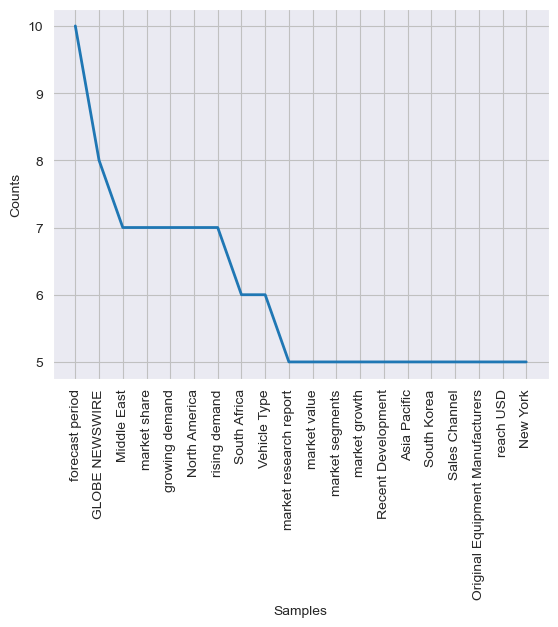

<AxesSubplot: xlabel='Samples', ylabel='Counts'>

In [14]:
all_chunks = []
for row in df['chunk_tokens']:
    all_chunks += row
freq = nltk.FreqDist(all_chunks)
freq.plot(20)